# Tractografía Determinista 
 
El código aquí presente es capaz de generar un tractograma (*.trk*) a partir de los datos del *Human Connectome Project* HCP de *Diffusion Weighted Imaging* DWI. Los datos necesarios para generar el tractograma son,
 
1. Archivos base donde se almacena la imagen del cerebro y sus tejidos adyacentes (*data.nii.gz*), cuantificando la difusión del agua en cada *voxel* (volumen mínimo de resolución) según la dirección de los gradientes para cada *bvec* y *bval* aplicado cuando se tomó la DWI. 
 
*   Archivos bvals y bvecs
*   data.nii.gz (imagen 3D para cada bvec aplicado)
 
2. Archivos de referencia preprocesados de mayor resolución que los datos. La máscara (*brainmask_fs.nii.gz*) contiene un arreglo 3D, tal que los voxeles con valores asociados diferentes a cero definen el volumen ocupado en la imagen por el cerebro, depurado de los tejidos externos como por ejemplo el cráneo. Por otro lado, la imagen T1w (*T1w_acpc_dc_restore_brain.nii.gz*) con bval=0, corresponde a un arreglo 3D de referencia sobre el cual es posible diferenciar la materia blanca *WM* de la materia gris *GM* y el líquido cerebroespinal *CSF* por sus propiedades magnéticas, reflejadas en las imágenes de resonancia magnética T1W.
 
*   brainmask_fs.nii.gz (máscara para aplicar a los datos de DWI)
*   T1w_acpc_dc_restore_brain.nii.gz (imagen para diferenciar los tejidos)

In [ ]:
#%% En el caso de Google Colaboratory, es necesario instalar las librerías necesarias para todos los análisis que se muestran adelante

In [ ]:
pip install dipy

In [ ]:
pip install nilearn

In [ ]:
pip install cvxpy

In [ ]:
pip install fury

In [ ]:
#%% Conectar con google drive, donde se encuentran los datos HCP1200 requeridos
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
#%% Montar librerías base para todo el proceso

import os
import subprocess
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

In [ ]:
#%% Visualización de los datos cargados del HCP1200

from scipy import ndimage  # Rotar las imagenes para mejor visualización

def plotdata(images):
  %matplotlib inline
  fa_img = images
  fig, ax = plt.subplots(1, 3, figsize=(10, 10))
  ax[0].imshow(ndimage.rotate(fa_img[:, fa_img.shape[1]//2, :], 90, reshape=False))
  ax[1].imshow(ndimage.rotate(fa_img[fa_img.shape[0]//2, :, :], 90, reshape=False))
  ax[2].imshow(ndimage.rotate(fa_img[:, :, fa_img.shape[-1]//2], 90, reshape=False))
  plt.show()

# Carga y Organización de los Datos
 
En esta sección se suben los datos de difusión y referencia para su posterior uso. Los datos de los gradientes aplicados contenidos en los archivos *bvals* y *bvecs* se condensan en una tabla de gradientes gtab, que corresponde al formato estándar usado por la librería DIPY para usarlos en los análisis de difusión. 
 
Todos los archivos NIFTI (*.nii.gz*) aparte de contener las imágenes que se buscan analizar, también vienen asociados con una matriz *affine*, que sirve como transformación para pasar de la representación de voxeles a las coordenadas espaciales del sistema, proporcionando además el tamaño de los voxeles en milímetros *voxel_size*; la matriz *affine* cobra importancia cuando se quieren redimensionar las imágenes de referencia para aplicarlas a los datos.


In [ ]:
#%% Leer y cargar las rutas de los datos del HCP

from os.path import expanduser, join

patient = '100610'
home = expanduser('/gdrive/Shareddrives/GENSyR /CNF (Complejidad y NeuroFísica)/Carpeta de trabajo/Proyecto lesiones/Tractografia')
dhcp = join(home, 'HCP_1200', patient)
dT1w = join(dhcp, 'T1w')
fraw = join(dT1w, 'Diffusion', 'data.nii.gz')
fbval = join(dT1w, 'Diffusion', 'bvals')
fbvec = join(dT1w, 'Diffusion', 'bvecs')
fmask = join(dT1w, 'brainmask_fs.nii.gz')
ft1 = join(dT1w, 'T1w_acpc_dc_restore_brain.nii.gz')

In [ ]:
#%% Cargar los datos del HCP1200, en este caso con su respectiva matriz affine y el tamaño de los voxeles en la imagen

from dipy.io.image import load_nifti_data, load_nifti, save_nifti

data, affine, voxel_size = load_nifti(fraw, return_voxsize=True) # Subir data de aprox 1gb es computacionalmente exigente y puede se demorado
t1_data, t1_affine, t1_voxel_size = load_nifti(ft1, return_voxsize=True)
mask_data, mask_affine, mask_voxel_size = load_nifti(fmask, return_voxsize=True) 

print('Observe que la dimensión de la imagen 3x3x3 para los datos ', data.shape, ' comparada con la de la imagen T1w y la máscara', t1_data.shape, ' ', mask_data.shape, ' no coinciden, por lo cual será necesario redimensionar estas imágenes de referencia o sus productos al tamaño de los datos')

Observe que la dimensión de la imagen 3x3x3 para los datos  (145, 174, 145, 288)  comparada con la de la imagen T1w y la máscara (260, 311, 260)   (260, 311, 260)  no coinciden, por lo cual será necesario redimensionar estas imágenes de referencia o sus productos al tamaño de los datos


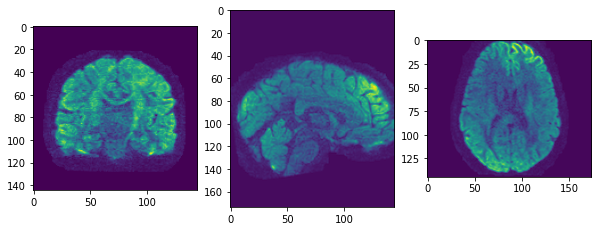

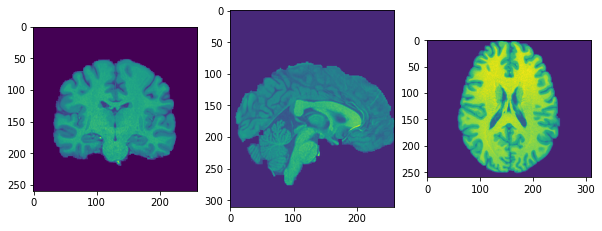

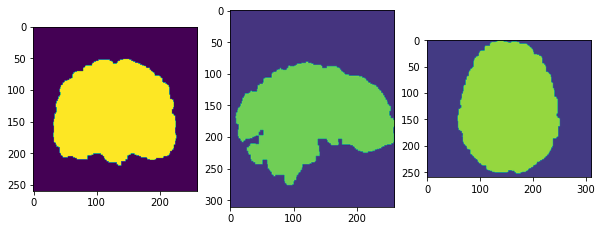

In [ ]:
#%% Se muestran los datos de difusión y las imágenes de referencia
plotdata(data[:,:,:,10]) # Como data contiene una dimensión extra para cada bvec, se considera la imagen para el bvec = bvecs[10] y bval[10] 
plotdata(t1_data)
plotdata(mask_data)

In [ ]:
#%% Leer los bvals y bvecs así como crear gtab

from dipy.core.gradients import gradient_table #, unique_bvals_tolerance, get_bval_indices, round_bvals
from dipy.io.gradients import read_bvals_bvecs

bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bvals, bvecs)

print('bvecs ', bvecs.shape, ' es un arreglo de vectores en diferentes direcciones de muestreo para la difusión y con valores bvals en un array de tamaño ', bvals.shape)

bvecs  (288, 3)  es un arreglo de vectores en diferentes direcciones de muestreo para la difusión y con valores bvals en un array de tamaño  (288,)


# Separación de Tejidos y Redimensión
 
La imagen de referencia T1w se utiliza para extraer tres máscaras con DIPY, como la que viene dada por el HCP, salvo que estas tres máscaras resaltan los volúmenes, o voxeles del cerebro donde se encuentra la materia blanca *wm*, la materia gris *gm*, y el líquido cerebroespinal *csf*.
 
Obtenidas estas máscaras para los tejidos y con la de referencia, se procede a redimensionar para que coincidan en resolución con los datos de DWI. En particular, la mascara de referencia redimensionada se aplica a los datos, definiendo una nueva imagen *datamask* depurada de tejidos ajenos al cerebro.
 
*Nota:* La separación de tejidos se realiza antes de la redimensión para así obtener máscaras de *gm*, *wm* y *csf* más precisas y que el proceso de interpolación que implica redimensionar una imagen no afecte a los datos de la imagen T1w.

In [ ]:
#%% Realizar la separación del tejido con la imagen de referencia de alta resolución T1w

from dipy.segment.tissue import TissueClassifierHMRF

nclass = 3 # Número de tejidos para los que obtener máscaras: csf, gm, wm
beta = 0.1 # Suavidad del trazado de las máscaras
hmrf = TissueClassifierHMRF()
initial_segmentation, final_segmentation, PVE = hmrf.classify(t1_data, nclass, beta) # Toma alrededor de 22 iteraciones, puede demorarse

# Máscaras sin redimensionar
csf = np.where(final_segmentation == 1, 1, 0)
gm = np.where(final_segmentation == 2, 1, 0)
wm = np.where(final_segmentation == 3, 1, 0)

In [ ]:
#%% Con las máscaras, se procede a redimensionarlas al tamaño de la imagen guía para las parcelas

from dipy.align.reslice import reslice

ds = data.shape
t1s = t1_data.shape
ms = mask_data.shape

t1_new_voxel_size = []
mask_new_voxel_size = []

for i in range(3):
    t1_new_voxel_size.append(t1s[i]*t1_voxel_size[i]/ds[i])
    mask_new_voxel_size.append(ms[i]*mask_voxel_size[i]/ds[i])

# Las máscaras quedan redimensionadas a la resolución de los datos con su respectiva matriz affine
rwm, rwm_affine = reslice(wm, t1_affine, t1_voxel_size, t1_new_voxel_size)
rgm, rgm_affine = reslice(gm, t1_affine, t1_voxel_size, t1_new_voxel_size)
rcsf, rcsf_affine = reslice(csf, t1_affine, t1_voxel_size, t1_new_voxel_size)

# Se redimensiona la máscara para aplicarla a los datos originales
rmask_data, rmask_affine = reslice(mask_data, mask_affine, mask_voxel_size, mask_new_voxel_size)

print('Si bien el tamaño de los voxeles de las máscaras redimensionadas ', t1_new_voxel_size, ' no cuadra exactamente con el de los datos ', voxel_size, ' la resolución de la imagen en voxeles si lo hace ', rwm.shape, ' lo que hace posible superponer los dos narrays y aplicar la máscara a los datos DWI')

Si bien el tamaño de los voxeles de las máscaras redimensionadas  [1.2551723924176446, 1.2511494039804085, 1.2551723924176446]  no cuadra exactamente con el de los datos  (1.25, 1.25, 1.25)  la resolución de la imagen en voxeles si lo hace  (145, 174, 145)  lo que hace posible superponer los dos narrays y aplicar la máscara a los datos DWI


In [ ]:
#%% Se guardan los datos de las máscaras ya redimensionadas al tamaño de los datos

frwm = join(dhcp,'wmresliced.nii.gz')
frgm = join(dhcp,'gmresliced.nii.gz')
frcsf = join(dhcp,'csfresliced.nii.gz')
maskresliced = join(dhcp,'maskresliced.nii.gz')

save_nifti(frwm, rwm, rwm_affine)
save_nifti(frgm, rgm, rgm_affine)
save_nifti(frcsf, rcsf, rcsf_affine)
save_nifti(maskresliced, rmask_data, rmask_affine)

In [ ]:
#%% Se aplica la máscara redimensionada a los datos 

from dipy.segment.mask import applymask

# Nuevos datos de referencia, sin los tejidos ajenos al cerebro
datamask = applymask(data, rmask_data)
datamask_affine = affine
datamask_voxel_size = voxel_size

In [ ]:
del data

In [ ]:
#%% Aplicada la máscara a los datos se guardan como un backup

fdatamask = join(dhcp,'datamask.nii.gz')
save_nifti(fdatamask, datamask, datamask_affine)

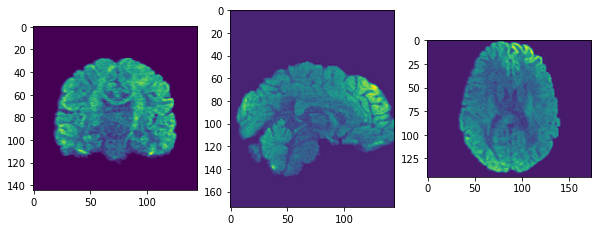

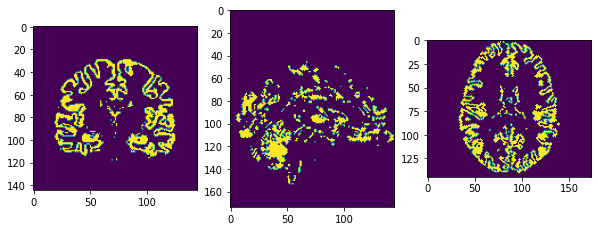

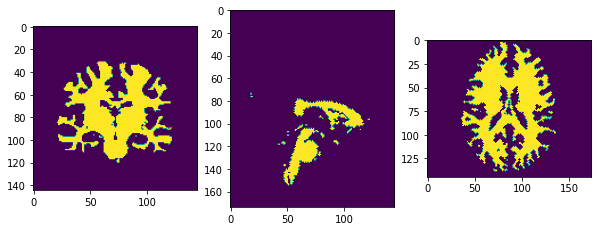

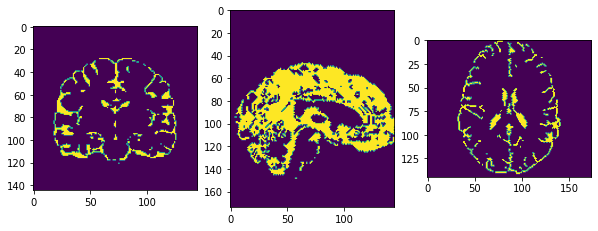

In [ ]:
# Se muestran los datos de difusión y las máscaras obtenidas
plotdata(datamask[:,:,:,10]) # Observe que al aplicar la máscara los tejidos ajenos al cerebro se eliminan de la imagen 
plotdata(rgm)
plotdata(rwm)
plotdata(rcsf)

# Modelo de Tractografía y Criterios para el Tractograma
 
En este parte se define el método por el cual estimar la difusión en cada uno de los voxeles de la imagen ya preprocesada. Para este caso el modelo será *TensorModel*, que tiene como parámetro *gtab*, que para cada voxel estima una matriz 3x3 cuyo máximo autovalor caracteriza con su respectivo autovector la recta de máxima difusión.
 
La dirección de los autovectores requiere ser discretizada sobre puntos predeterminados en una esfera (*symetric362*) que DIPY utiliza para la reconstrucción de los tractos.
 
Por otro lado, para la reconstrucción de los tractos es necesario definir los lugares donde la tractografía, que reconstruye trayectorias con el método de Euler (*EuDx*), empieza y termina. Se define una semilla (*seeds*) sobre la materia blanca (rwm) donde se buscan estimar los tractos nerviosos, y se define un *StoppingCriterion* que tiene en cuentas los tejidos hallados previamente (*rwm, rgm y rcsf*) para considerar si el tracto alcanza una región válida o no; en este caso la región válida será cuando el tracto alcanza la frontera entre la materia blanca y la materia gris.



In [ ]:
#%% Se define el modelo tensorial para aplicar a los voxeles, que recibe como parámetro gtab, es decir, la informacion de los gradientes y constantes importantes relevantes para hallar el tensor

import dipy.reconst.dti as dti

dti_model = dti.TensorModel(gtab)

In [ ]:
#%% Generar los picos en cada voxel para la tractografáa 

# Se carga la esfera de 362 puntos sobre la que los autovectores asociados a los tensores en cada voxel se proyectaran
from dipy.data import get_sphere
sphere = get_sphere('symmetric362')

from dipy.direction import peaks_from_model

# Se determinan las direcciones o picos de máxima difusión para cada voxel, esta parte puede tardar un rato
peak_indices = peaks_from_model(
    model=dti_model, data=datamask, sphere=sphere, relative_peak_threshold=.2,
    min_separation_angle=25, mask=rmask_data, npeaks=2)

In [ ]:
#%% Generar los criterios para empezar y parar los tractos nerviosos 
from dipy.tracking import utils
from dipy.tracking.stopping_criterion import CmcStoppingCriterion

voxel_size_mask = np.average(t1_new_voxel_size)
step_size = 0.5

# Se definen las semillas de la tractografía con la máscara de materia blanca
seeds = utils.seeds_from_mask(rwm, datamask_affine, density=1)

# Se define el Stopping Criterion con las máscaras de los tres tejidos rwm, rgm, rcsf
cmc_criterion = CmcStoppingCriterion.from_pve(rwm,
                                              rgm,
                                              rcsf,
                                              step_size=step_size,
                                              average_voxel_size=voxel_size_mask)

# Creación de los Tractogramas
 
Con la dirección de difusión para cada voxel en la imagen de difusión y definidos los criterios de inicio y final, se procede a reconstruir los tractos teniendo a las direcciones de máxima difusión como los vectores tangentes a las curvas que se consideran como los tractos en la materia blanca, definiendo así una ecuación diferencial de primer orden que será resuelta con el método de Euler en DIPY. Esta curva en reconstrucción parte de las semillas en la materia blanca y se detiene cuando llega a la materia gris o se topa con un voxel donde no hay suficiente información para continuar determinando localmente la trayectoria.
 
Existen múltiples formas de hacer tractografía, el método que se usará aquí será ParticleFilteringTracking, que reconstruye los tractos y es capaz de identificar con el *CmcStoppingCriterion* en qué tejido terminan; si este termina en la materia gris será conservado; en caso contrario el método encuentra otro fragmento de trayectoria, sobre el cual seguir corriendo la ecuación diferencial, uniendola al tracto para extenderlo así hasta la materia gris.
 
Finalmente con los tractos (*streamlines*), estas se guardan en un archivo (*.trk*) en un formato de representación estándar *RASMM*. Este archivo o tractograma se usará luego para generar la matriz de conectividad estructural.

In [ ]:
#%%  Se define la Particle Filtering Tractography, enviando como parámetro las semillas, el StoppingCriterion y los picos para cada voxel

from dipy.tracking.local_tracking import (LocalTracking,ParticleFilteringTracking)

pft_streamline_generator = ParticleFilteringTracking(peak_indices,
                                                     cmc_criterion,
                                                     seeds,
                                                     datamask_affine,
                                                     max_cross=1,
                                                     step_size=step_size,
                                                     maxlen=1000,
                                                     pft_back_tracking_dist=2,
                                                     pft_front_tracking_dist=1,
                                                     particle_count=15,
                                                     return_all=False)

In [ ]:
#%% Definido el tipo de tractografía, con Streamlines se generan las curvas como se especificó arriba

from dipy.tracking.streamline import Streamlines

pft_streamlines = Streamlines(pft_streamline_generator)

In [ ]:
#%% Guardar tractograma en archivo trk con el formato canónico RAS+ en mm

from dipy.io.stateful_tractogram import Space, StatefulTractogram
from dipy.io.streamline import save_tractogram

# Para generar el tractograma pft_sft es necesario enviar como parámetro el archivo NIFTI de donde se obtuvieron los tractos
route= fdatamask
data_img = nib.load(route)

# Se genera el tractograma en el espacio RASMM
pft_sft = StatefulTractogram(pft_streamlines, data_img, Space.RASMM)

# Se guarda el tractograma en formato trk, este se puede visualizar con el programa TrackVis o cargandolo a python como se verá más adelante
nametracto = 'tractogram_deterministic_EuDX_pft_' + patient + '.trk'
ftrackpft = join(dhcp,nametracto)
save_tractogram(pft_sft, ftrackpft) 


True

In [ ]:
#%% Visualización interactiva del tractograma con fury

from dipy.viz import window, actor, colormap, has_fury
interactive = False

streamlines = pft_streamlines

if has_fury:
    scene = window.Scene()
    scene.add(actor.line(streamlines, colormap.line_colors(streamlines)))
    window.record(scene, out_path='tractogram_pft.png',
                  size=(800, 800))
    if interactive:
        window.show(scene)

# Creación de la Matriz de Conectividad Estructural
 
Con el tractograma ya determinado, se procede a utilizar una parcelación cortical y sub-cortical para definir los nodos, y mediante el conteo de los tractos que van de una región específica a otra, caracterizar el peso y los links, que se almacenan en la matriz de conectividad estructural *M*.
 
*Nota:* Si bien la dimensión y la matriz *affine* de la parcela no necesariamente coinciden con la de los datos de DWI, parece ser que la función *connectivity_matrix* realiza los ajustes respectivos para poder comparar los datos y construir *M*; aunque la documentación no es clara al respecto.

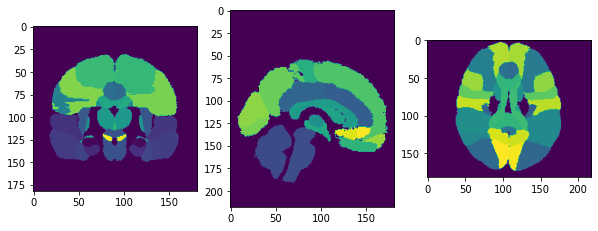

In [ ]:
#%% Importar parcelación que se usará para definir los nodos de la red. 

from nilearn import datasets
from dipy.io.image import load_nifti_data, load_nifti, save_nifti

fparcelas = '/gdrive/Shareddrives/GENSyR /CNF (Complejidad y NeuroFísica)/Carpeta de trabajo/Datos /Hammersmith_space-MNI152NLin6_res-1x1x1.nii.gz'
par_data, par_affine = load_nifti(fparcelas)

#print(' Observe que el tamaño de la parcela ', par_data.shape, ' no coincide con la de los datos ', datamask.shape)
#print(' Por otra parte, tampoco lo hacen las matrices affine. La de la parcela ' par_affine, ' y la de los datos ' , datamask_affine)

plotdata(par_data)

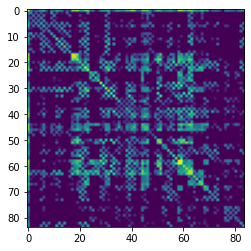

In [ ]:
#%% Con los datos del tractograma se procede a crear la matriz con la parcela elegida anteriormente, esto se hará por medio del conteo de tractos que van
#%% de una parcela a otra, definiendo un link pesado

# Cargar el archivo trk en una variable streamsObjIN
streamsObjIN=nib.streamlines.load(ftrackpft)

from dipy.tracking import utils

# Se extrae la matriz de conectividad M pasando la matriz affine y la imagen de la parcelación correspondiente
streamspar = streamsObjIN.tractogram.streamlines
M, grouping=utils.connectivity_matrix(streamspar, par_affine, label_volume=par_data.astype(int), return_mapping=True, mapping_as_streamlines=False)

# La matriz M se guarda en un archivo npy y se carga con np.load
festconnectivity = join(dhcp, 'matrix_estructural_connectivity.npy')
np.save(festconnectivity, M)

# Para visualizar los datos de manera más sencilla las entradas de la matriz se redimensionan 
K = np.log1p(M)
plt.imshow(K)


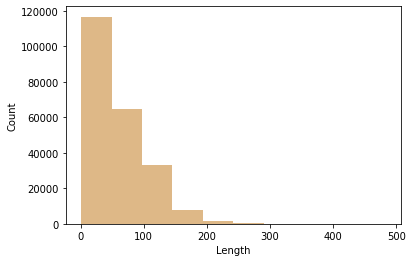

In [ ]:
type(grouping)
len(pft_streamlines)
#len(pft_sft)
from dipy.tracking.utils import length

lengths = list(length(pft_streamlines))

fig_hist, ax = plt.subplots(1)
ax.hist(lengths, color='burlywood')
ax.set_xlabel('Length')
ax.set_ylabel('Count')
plt.show()
#plt.legend()
#plt.savefig('length_histogram.png')

In [ ]:
len(lengths)
lengths[100000]

40.99999999999999